# load trajectories and extract their features

In [1]:
from tramway.analyzer import *

a = RWAnalyzer()

a.spt_data.from_ascii_file('trajectories.txt')
a.spt_data.localization_precision = 0.

for f in a.spt_data: # single iteration
    trajectories = f.dataframe
    
trajectories

/home/flaurent/github/RWA-python/rwa/hdf5.py:185: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel # Panel has been flagged deprecated


,n,x,y,t
0,1,-0.478794,-0.337067,0.50
1,1,-0.474625,-0.185356,0.55
2,1,-0.250008,-0.239683,0.60
3,1,-0.144937,-0.307840,0.65
4,2,0.488249,-0.363448,1.15
...,...,...,...,...
2353,400,-0.336608,-0.666218,297.70
2354,400,-0.315750,-0.636530,297.75
2355,400,-0.418443,-0.517603,297.80
2356,400,-0.526123,-0.661685,297.85


In [2]:
from tramway.feature.single_traj import extract_features

trajectory_features = extract_features(trajectories, None, pbar=False)
trajectory_features

,size,dt,is_dt_cst,t_min,t_max,angle_var,angle_autocorr1,angle_autocorr2,drift_norm,ergo_x,...,straightness,step_mean,step_var,step_skewness,step_kurtosis,step_min,step_max,autocorr_1,autocorr_2,autocorr_3
n,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.05,True,0.0,0.15,0.520203,-1.000000,NaN,2.076222,0.401688,...,0.659580,0.169367,0.002022,0.527098,-1.500000,0.125241,0.231093,-0.942008,0.384015,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.0,0.05,True,0.0,0.45,0.595723,-0.018595,-0.344950,1.087552,0.285406,...,0.146561,0.123766,0.004052,-0.000814,-1.351810,0.032503,0.211370,-0.473232,-0.449257,0.704455
5,9.0,0.05,True,0.0,0.40,0.325213,-0.006164,-0.715772,1.844992,0.569021,...,0.444382,0.125012,0.003991,0.457845,-0.704484,0.038465,0.242871,-0.742922,0.170545,0.356374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,8.0,0.05,True,0.0,0.35,0.739834,0.150526,-0.922980,0.739494,0.204542,...,0.075527,0.134414,0.003540,0.246328,-0.402138,0.037403,0.242482,-0.617265,0.537255,-0.897359
397,10.0,0.05,True,0.0,0.45,0.572805,-0.202435,0.445901,1.111505,0.276295,...,0.316833,0.118229,0.004442,0.352788,-0.936124,0.034764,0.243186,-0.696259,0.243752,0.092522
398,21.0,0.05,True,0.0,1.00,0.641618,-0.109310,-0.257905,1.269253,0.351346,...,0.525774,0.129853,0.004646,0.615094,-0.610374,0.030710,0.274961,-0.143082,0.020704,0.055001


# specify how to average the trajectory features per bin

In [3]:
import numpy as np
import pandas as pd

def get_feature_summary(func=pd.DataFrame.mean):
    # name `summary` is borrowed from R's summary function
    def infer(cells):
        index = []
        mean_features = []
        for i in cells:
            trajectory_indices = cells[i].n
            mean_features_i = func(trajectory_features.loc[trajectory_indices], skipna=True)
            index.append(i)
            mean_features.append(mean_features_i.values)
        return pd.DataFrame(np.stack(mean_features), index=index, columns=trajectory_features.columns)
    return infer

In [4]:
a.tesseller = tessellers.Hexagons
a.mapper.from_plugin(get_feature_summary(pd.DataFrame.median))

# average the trajectory features per bin

In [5]:
for f in a.spt_data: # single iteration
    
    # tessellate, assign and compute per-bin estimates
    trajectories = f.dataframe
    sampling = a.sampler.sample(trajectories)
    maps = a.mapper.infer(sampling)
    
    # optional; for saving to file only
    sampling_label = 'hexagon'
    maps_label = 'trajectory features'
    _sampling = commit_as_analysis(sampling_label, sampling, parent=f)
    _maps = commit_as_analysis(maps_label, maps, parent=_sampling)
    
maps.maps

,size,dt,is_dt_cst,t_min,t_max,angle_var,angle_autocorr1,angle_autocorr2,drift_norm,ergo_x,...,straightness,step_mean,step_var,step_skewness,step_kurtosis,step_min,step_max,autocorr_1,autocorr_2,autocorr_3
6,11.0,0.05,1.0,0.0,0.50,0.510244,-0.056070,-0.460425,1.226056,0.160809,...,0.557671,0.130088,0.003085,0.159550,-0.820952,0.057882,0.228083,-0.273598,-0.222125,0.099127
7,11.0,0.05,1.0,0.0,0.50,0.524876,-0.153410,0.091658,1.361268,0.351346,...,0.336886,0.143972,0.003472,0.357673,-0.767473,0.045290,0.232960,0.074784,-0.305961,0.042807
8,11.0,0.05,1.0,0.0,0.50,0.670773,-0.237197,-0.010863,2.249161,0.403132,...,0.449816,0.139961,0.004287,-0.371712,-1.094548,0.026258,0.232225,0.555456,-0.194636,-0.337311
10,8.0,0.05,1.0,0.0,0.35,0.747028,-0.162268,-0.345055,1.076444,0.227108,...,0.362527,0.131961,0.003581,0.204770,-0.957260,0.051803,0.215750,-0.244946,-0.188741,-0.140586
11,10.0,0.05,1.0,0.0,0.45,0.666226,-0.148814,-0.071889,0.895540,0.263758,...,0.286578,0.129331,0.003453,0.396727,-0.917027,0.037403,0.228083,-0.150604,-0.074714,-0.090647
12,11.0,0.05,1.0,0.0,0.50,0.670773,-0.153410,-0.150490,0.884930,0.241969,...,0.292475,0.128176,0.003557,0.342669,-0.822239,0.039095,0.229701,-0.113176,-0.166232,-0.129531
13,24.0,0.05,1.0,0.0,1.15,0.666226,-0.036177,-0.114317,0.842444,0.026335,...,0.363294,0.128176,0.003818,0.323428,-0.807034,0.025864,0.249446,-0.113176,0.359617,0.061127
14,22.0,0.05,1.0,0.0,1.05,0.813461,-0.054453,-0.551473,1.323086,0.221918,...,0.202937,0.132543,0.006091,0.826271,-0.571838,0.036356,0.289006,0.085039,-0.240651,-0.183931
15,9.0,0.05,1.0,0.0,0.40,0.653299,-0.109310,-0.261463,1.051058,0.242346,...,0.318433,0.132292,0.003643,0.343086,-0.979086,0.040542,0.242285,-0.140766,-0.117596,-0.107085
16,10.0,0.05,1.0,0.0,0.45,0.707009,-0.135868,-0.269402,0.962279,0.227132,...,0.291947,0.123766,0.003793,0.311393,-0.726329,0.032674,0.235406,-0.106356,-0.041656,-0.273599


# plot the average features

/home/flaurent/github/TRamWAy/tramway/helper/inference.py:1070: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = mplt.figure(figsize=figsize, dpi=dpi)


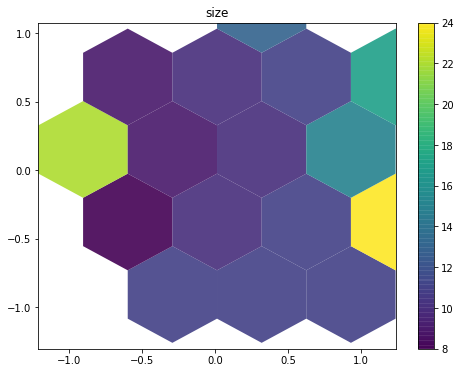

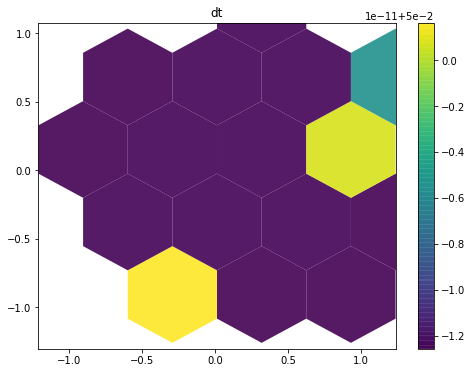

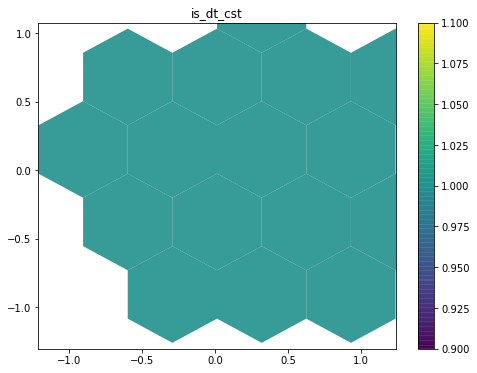

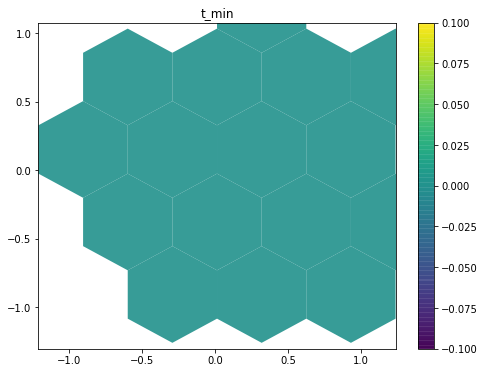

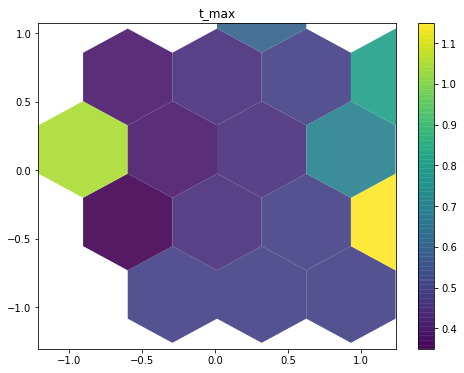

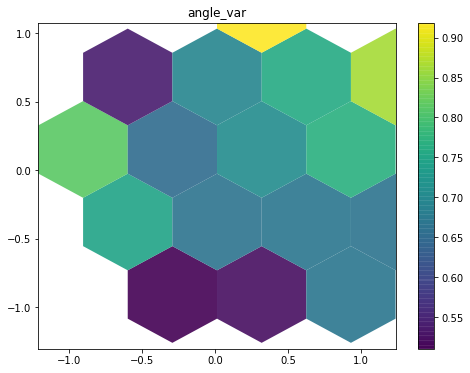

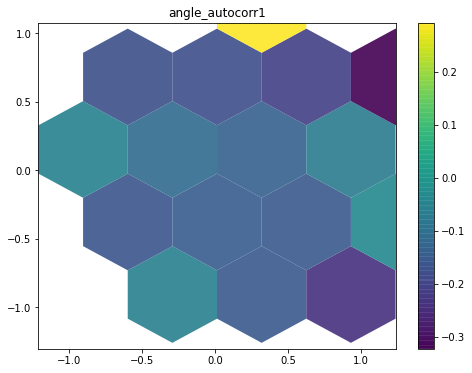

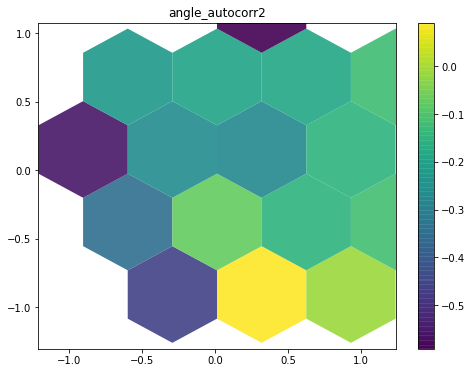

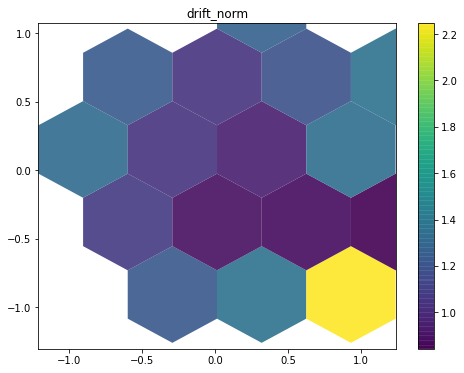

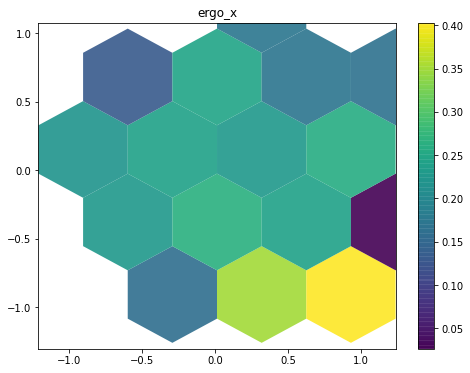

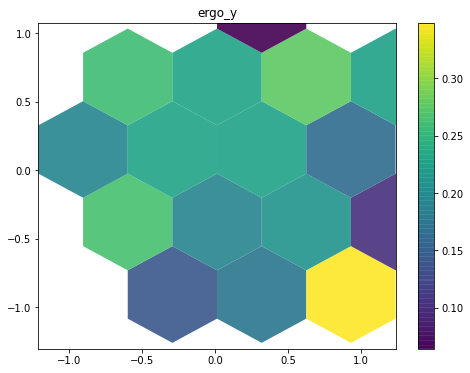

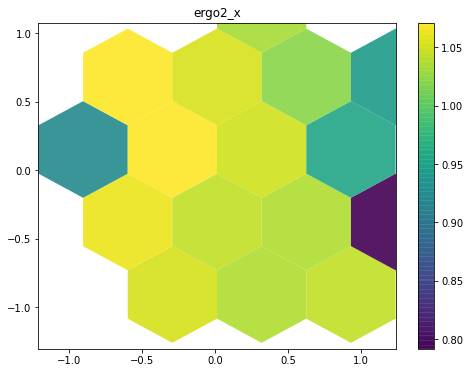

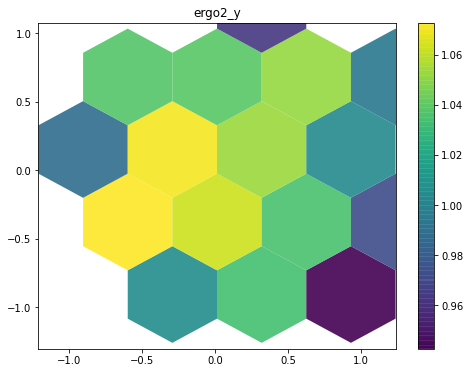

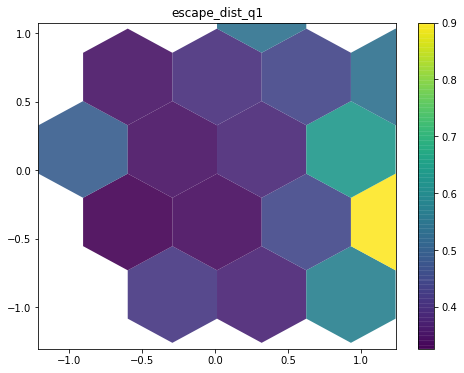

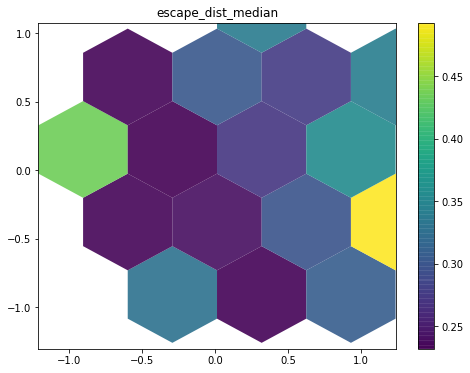

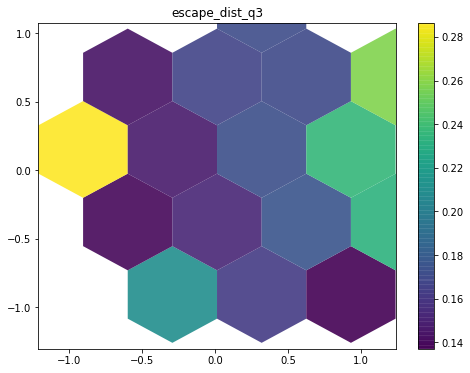

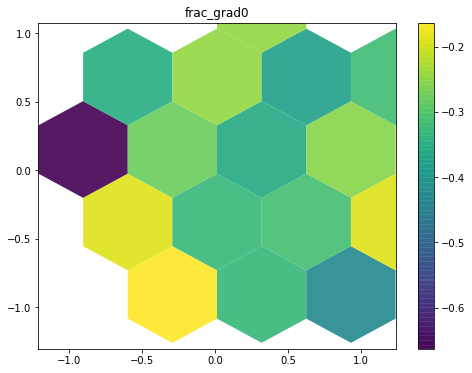

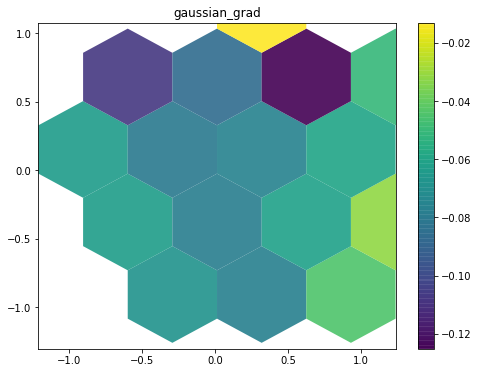

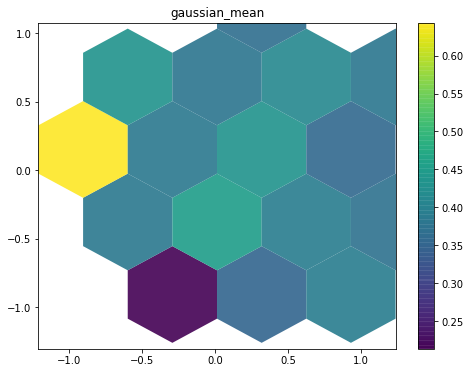

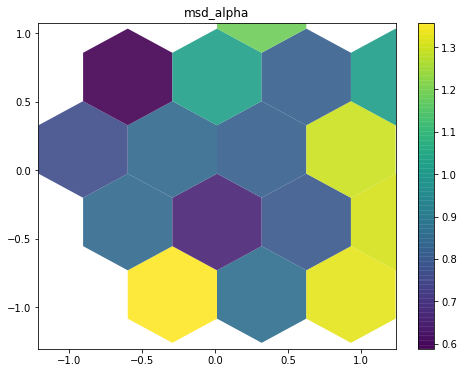

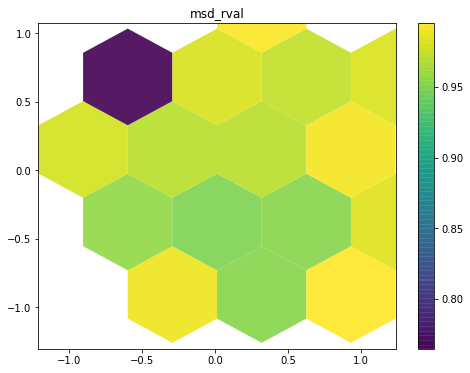

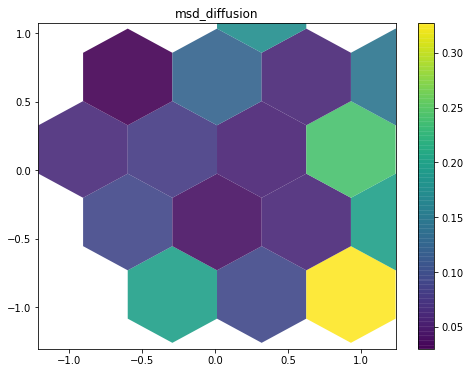

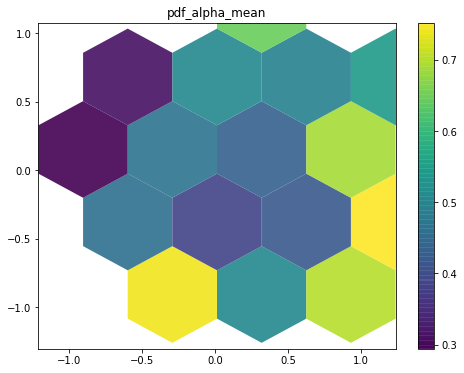

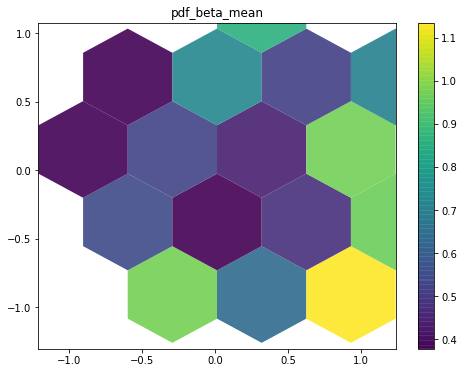

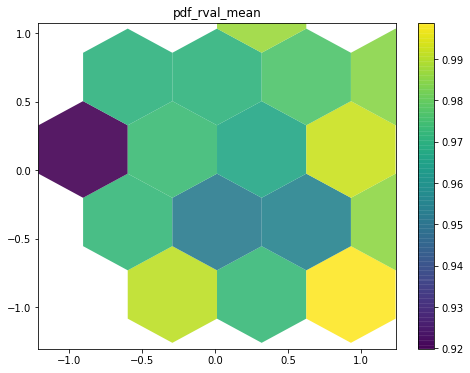

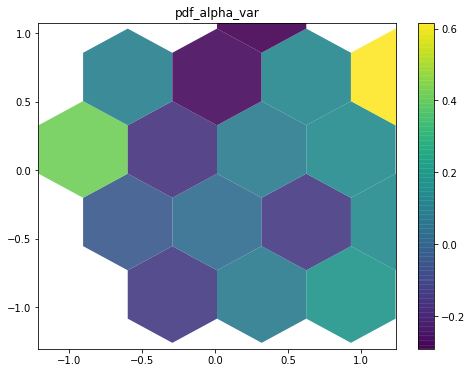

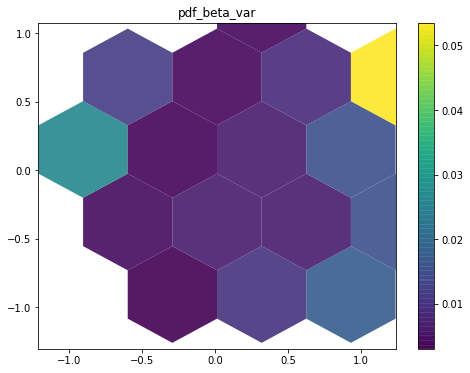

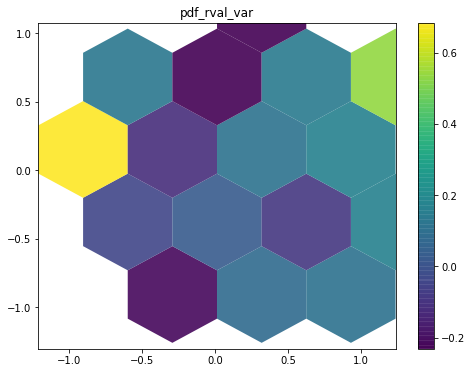

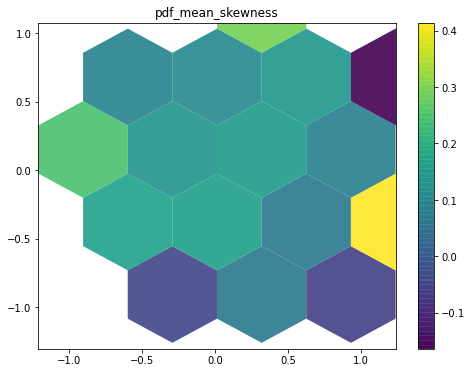

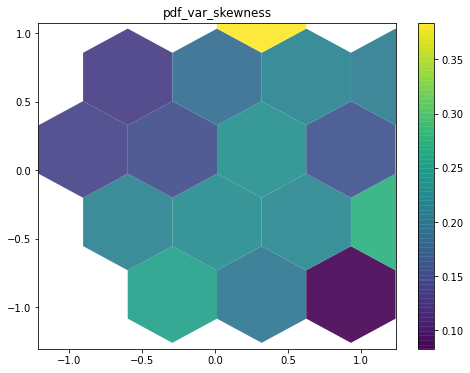

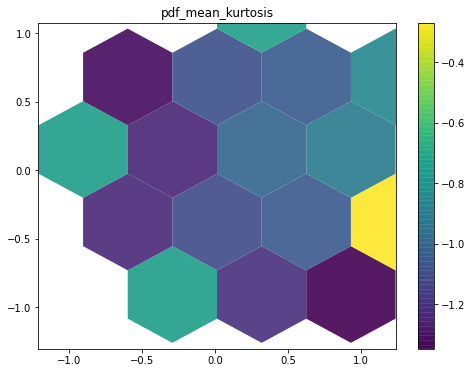

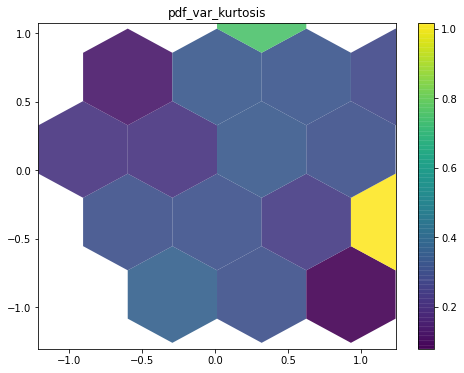

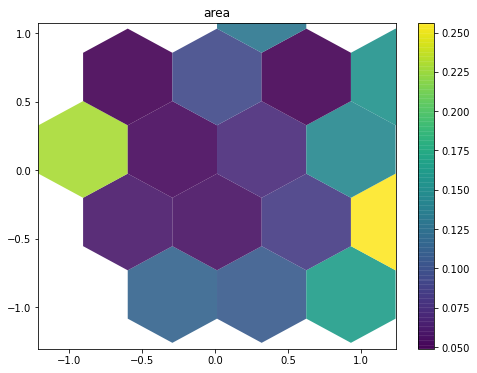

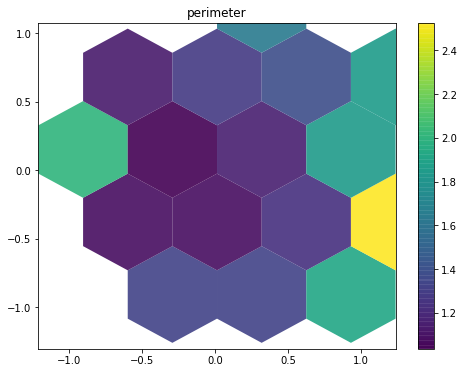

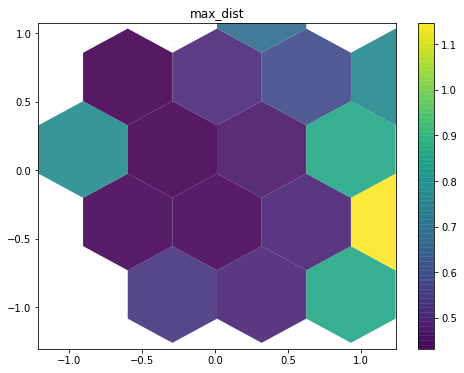

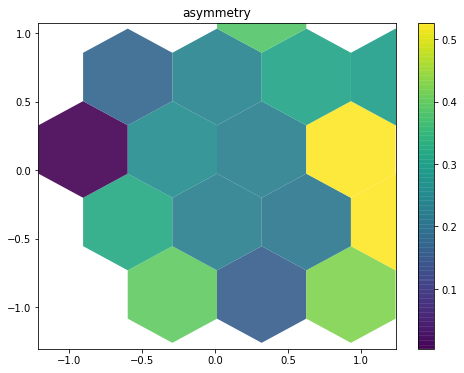

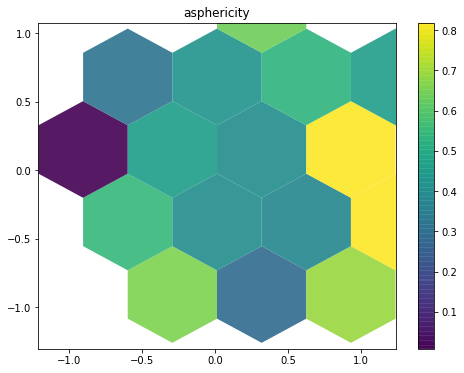

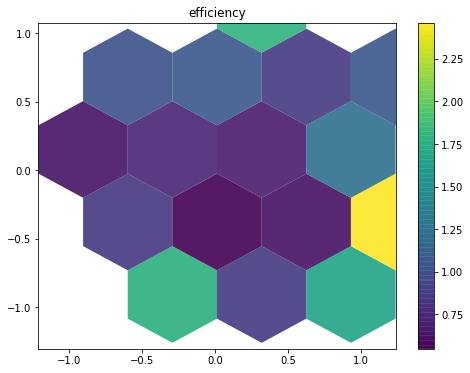

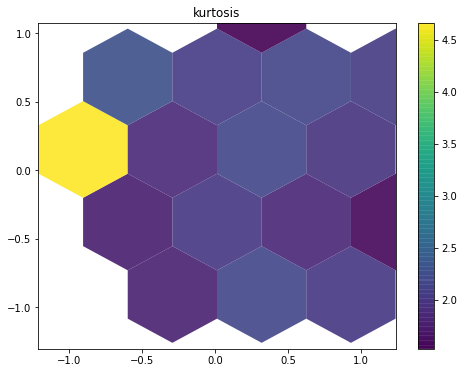

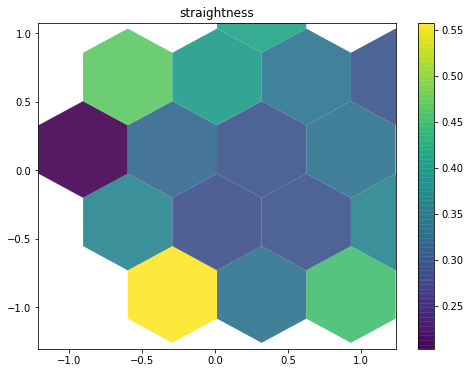

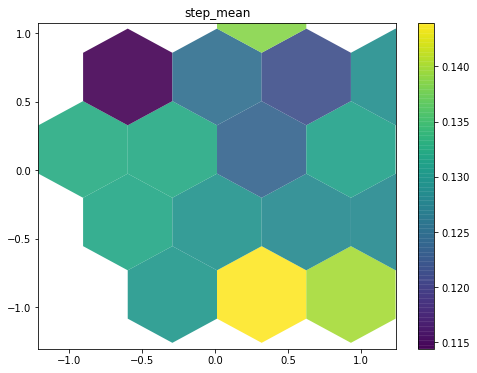

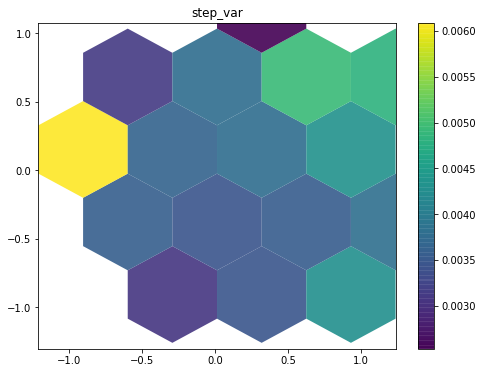

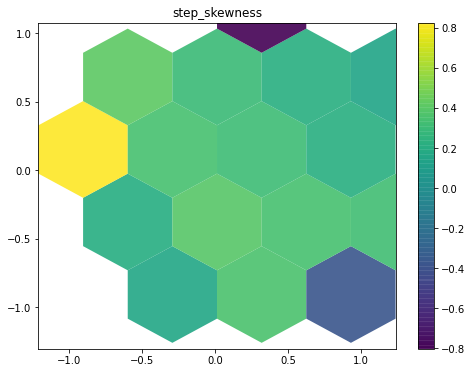

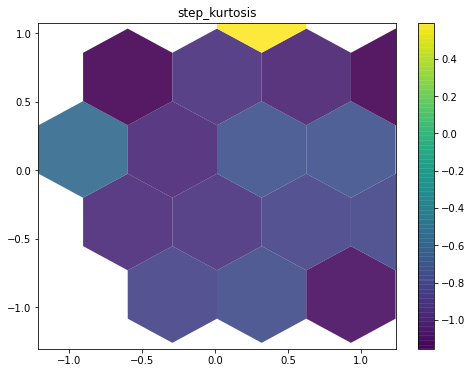

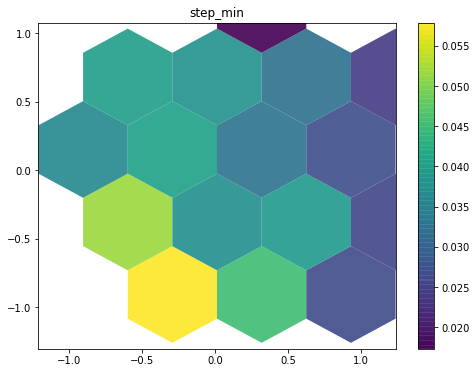

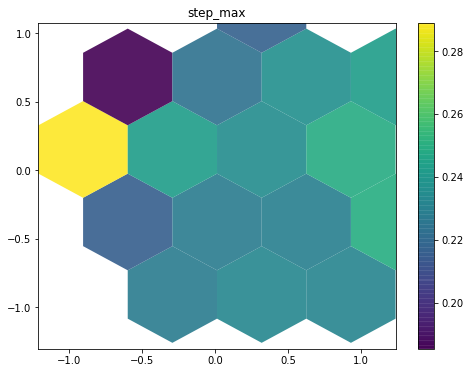

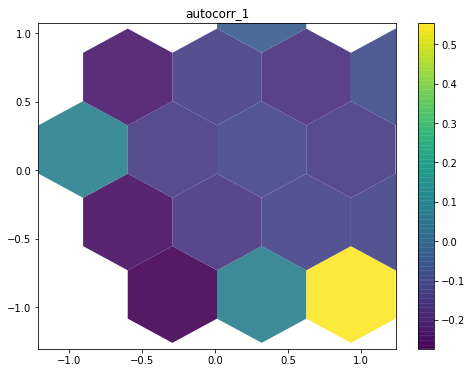

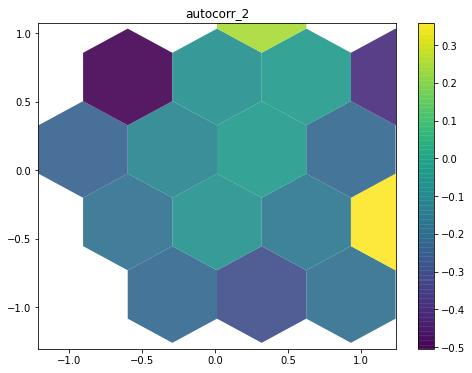

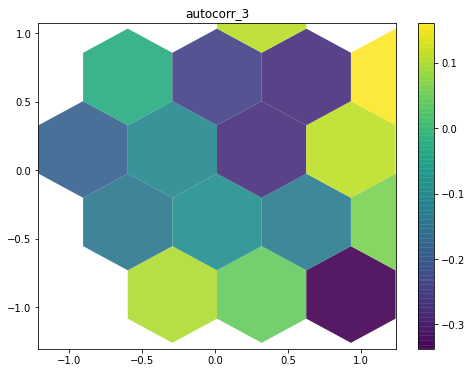

In [6]:
from tramway.helper.inference import map_plot

_=map_plot(maps, sampling, figsize=(8,6), mode=False)